In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pylab import plot
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import data 
#data can be found at https://www.kaggle.com/rajeevw/ufcdata
source_data = pd.read_csv('data.csv')
df = source_data

In [3]:
#Create Unique ID for each fighter 
df['R_ID'] = ["R_ID" + str(x) for x in range(1, len(df.R_fighter)+1)]
df['B_ID'] = ["B_ID" + str(x) for x in range(1, len(df.B_fighter)+1)]

##### Spread Analyis

In [4]:
#Create two data frames, 1 winner, 1 losers
# columns describe the difference in fighters, age, reach, weight, height
df['Won'] = df['Winner'].apply(lambda x: 1 if x == 'Red' else 0)
df['Age_Spread'] = df['R_age'] - df['B_age']
df['Reach_Spread'] = df['R_Reach_cms'] - df['B_Reach_cms']
df['Weight_Spread'] = df['R_Weight_lbs'] - df['B_Weight_lbs']
df['Height_Spread'] = df['R_Height_cms'] - df['B_Height_cms']
df_spread = df
df_win = df.loc[df['Won'] == 1]
df_lose = df.loc[df['Won'] == 0]

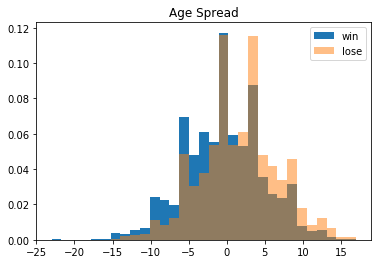

In [5]:
#graph the winners and losers by age spread as a histogram
#shows that younger fighters, those with a negative age spread, tend to win more
#shows that older fighters, those with a positive age spread, tend to lose more
#age spread is a relevant factor for predicting winners and losers

d1 = df_win['Age_Spread']
d2 = df_lose['Age_Spread']
bins = np.linspace(min(d1.min(), d2.min()), max(d1.max(), d2.max()), 32)
plt.hist(d1, density = True, label = 'win', bins = bins)
plt.hist(d2, density = True, label = 'lose', alpha = .5, bins = bins)
plt.title('Age Spread')
plt.legend();

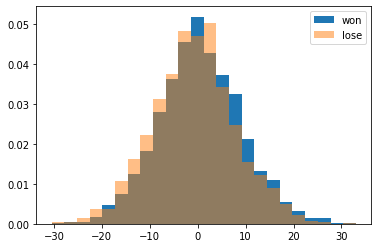

In [6]:
#Histogram showing winners/losers by reach_spread
#appears that winners have positive reach spread thus a relevant factor for predicing

d1 = df_win['Reach_Spread']
d2 = df_lose['Reach_Spread']
bins = np.linspace(min(d1.min(), d2.min()), max(d1.max(), d2.max()), 25)
plt.hist(d1, density = True, label = 'won', bins = bins)
plt.hist(d2, density = True, label = 'lose', bins = bins, alpha = .5);
plt.legend()


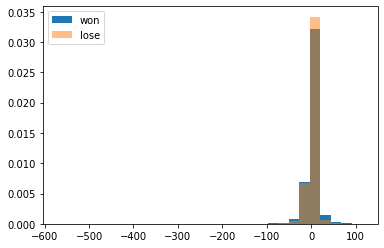

In [7]:
#first attempt at plotting histogram of wins by weight spread
#Outliers are preventing the visualization from giving us detailed information 
#We will have to further clean the data
d1 = df_win['Weight_Spread']
d2 = df_lose['Weight_Spread']
bins = np.linspace(min(d1.min(), d2.min()), max(d1.max(), d2.max()), 30)
plt.hist(d1, density = True, bins = bins, label = 'won')
plt.hist(d2, density = True, bins = bins, label = 'lose', alpha = .5)
plt.legend()


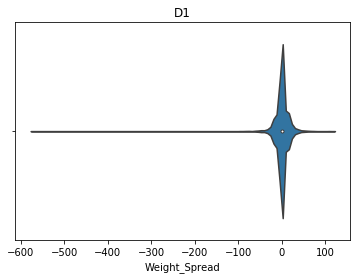

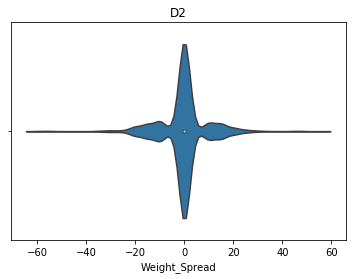

In [8]:
#shows that D1 has major outliers to the left, probably due to incomplete data for oppenent weight 
#Also shows that the majority of weight spread sits around 0. This makes sense as fighters fight in their weight class
sns.violinplot(d1)
plt.title('D1')
plt.show()
sns.violinplot(d2)
plt.title('D2')
plt.show()

In [9]:
#Get the Z score for each record
z = d1.dropna()
z_score = np.abs(stats.zscore(z))
z_score = pd.Series(z_score)
z = z.reset_index()
d1 = pd.concat([z['Weight_Spread'], z_score], axis = 1)
z = d2.dropna()
z_score = np.abs(stats.zscore(z))
z_score = pd.Series(z_score)
z = z.reset_index()
d2 = pd.concat([z['Weight_Spread'], z_score], axis = 1)

In [10]:
#Remove outliers with z score of more than 3 
d1.rename(columns = {0: 'z_score'},inplace = True)
d2.rename(columns = {0: 'z_score'}, inplace = True)
d1 = d1.loc[d1['z_score'] < 3]
d2 = d2.loc[d2['z_score'] < 3]

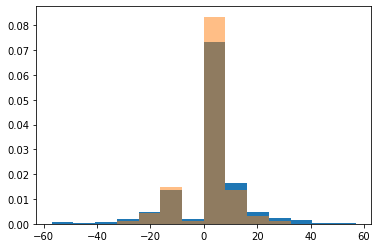

In [11]:
#Graph is now easier to read
#Still cannot see a clear relationship between weight spread and win/lose
#Will not use weight spread in final model 
bins = np.linspace(min(d1['Weight_Spread'].min(), d2['Weight_Spread'].min()), max(d1['Weight_Spread'].max(), d2['Weight_Spread'].max()), 15)
plt.hist(d1['Weight_Spread'], bins = bins, density = True, label = 'win')
plt.hist(d2['Weight_Spread'], bins = bins, density = True, label = "lose", alpha = .5);

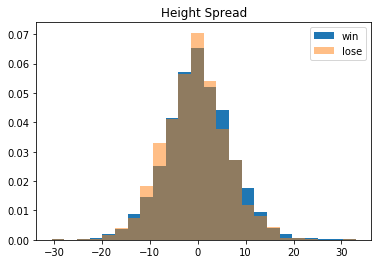

In [12]:
#Histogram showing winners/losers by height_spread
#this graph looks similar to reach spread 
#We see that the two fields are highly correlated below. 
#Will not use Height Spread in model as effects are captured through reach spread
d1 = df_win['Height_Spread']
d2 = df_lose['Height_Spread']
bins = np.linspace(min(d1.min(), d2.min()), max(d1.max(), d2.max()), 25)
plt.hist(d1, density = True, label = 'win', bins = bins)
plt.hist(d2, density = True, label = 'lose', alpha = .5, bins = bins)
plt.title('Height Spread')
plt.legend();


In [13]:
#Shows correlation between height_spread and reach_spread
df[['Height_Spread','Reach_Spread']].corr()

Height_Spread  Reach_Spread
Height_Spread       1.000000      0.652131
Reach_Spread        0.652131      1.000000

##### K Means Grouping 

In [14]:
df = source_data
columns = df.columns


In [15]:
#Group fields by fighter Red, Blue, and neither
R_stats = []
for column in columns: 
    if 'R_' in column[0:2]:
        R_stats.append(column)
        
B_stats = []
for column in columns:
    if 'B_' in column[0:2]:
        B_stats.append(column)
factors = []

for column in columns:
    if column not in R_stats and column not in B_stats:
        factors.append(column)


In [16]:
#Create of list that will be final column names
#Create lists that will be used to extract fields from main df
column_names = []

for n in R_stats:
    column_names.append(n[2:])

R_stats = R_stats + factors
B_stats = B_stats + factors
column_names = column_names + factors

In [17]:
#Create data frames based on red fighter and blue fighter
#Stack data frames ontop of eachother to create one population
df_R = df[R_stats]
df_B = df[B_stats]

df_R.columns = column_names
df_B.columns = column_names

df_R['won'] = df_R['Winner'].apply(lambda x: 1 if x == 'Red' else 0)
df_B['won'] = df_B['Winner'].apply(lambda x: 1 if x == 'Blue' else 0)
df = pd.concat([df_R,df_B])
main_df = df
;

C:\Users\ch9294774\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\ch9294774\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


''

In [18]:
#Create a list that has fields describing the hits landed
#ID starts in there just to keep it in the new df, it is removed from list later on 
strike_list = ['avg_BODY_att', 'avg_BODY_landed', 'avg_CLINCH_att',
       'avg_CLINCH_landed', 'avg_DISTANCE_att', 'avg_DISTANCE_landed',
       'avg_GROUND_att', 'avg_GROUND_landed', 'avg_HEAD_att',
       'avg_HEAD_landed', 'avg_KD', 'avg_LEG_att', 'avg_LEG_landed',
       'avg_PASS', 'avg_REV', 'avg_SIG_STR_att', 'avg_SIG_STR_landed',
       'avg_SIG_STR_pct', 'avg_SUB_ATT', 'avg_TD_att', 'avg_TD_landed',
       'avg_TD_pct', 'avg_TOTAL_STR_att', 'avg_TOTAL_STR_landed',]
landed_list = ['ID']

for n in strike_list:
    if n[-6:] == 'landed':
        landed_list.append(n)
landed_list

df_landed = df[landed_list]
landed_list.remove('ID')
df_landed = df_landed.dropna()

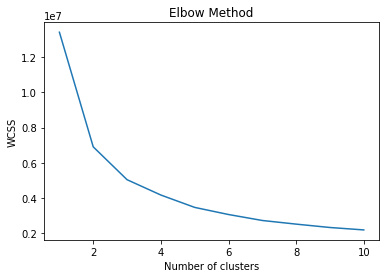

In [19]:
#to determine the amount of clusters we use for k means
#We will opt for 4 based on the output 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_landed[landed_list])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
#Run K means to group fighters in to 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_landed[landed_list])
predict = kmeans.predict(df_landed[landed_list])
df_landed['cluster'] = pd.Series(predict, index = df_landed.index)
df_landed = df_landed.merge(df[['ID','won']], on = 'ID', how = 'left')
df_landed = df_landed.merge(df[['ID','weight_class']], on = 'ID', how = 'left')
df_landed_won = df_landed.loc[ df_landed['won'] == 1]
df_landed_lost = df_landed.loc[ df_landed['won'] == 0]

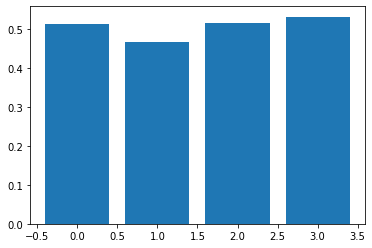

In [21]:
# Shows that certain clusters win more on average than others
#Will use clusters in our model 
d1 = df_landed[['cluster','won']].groupby(['cluster'],as_index = False).mean()
plt.bar(x = d1['cluster'], height = d1['won']);

### Predictive Model
#### We will use age_spread, reach_spread, and our clusters as fields in our model

In [22]:
#Functions to look up age spread and reach spread from previous data frames
def age_spread(x):
    if x[0] == 'R':
        y = df_spread.loc[df_spread['R_ID'] == x]
        return y.iloc[0]["Age_Spread"]
    else:
        y = df_spread.loc[df_spread['B_ID'] == x]
        return np.negative(y.iloc[0]["Age_Spread"])
    
def reach_spread(x):
    if x[0] == 'R':
        y = df_spread.loc[df_spread['R_ID'] == x]
        return y.iloc[0]["Reach_Spread"]
    else:
        y = df_spread.loc[df_spread['B_ID'] == x]
        return np.negative(y.iloc[0]["Reach_Spread"])


In [23]:
# create data frame with all relevant factors for modeling 
df_main = df
df_main['ID'].head()
df_main['age_spread'] = df_main['ID'].apply(lambda x: age_spread(x))
df_main['reach_spread'] = df_main['ID'].apply(lambda x: reach_spread(x))
df_main = df_main.merge(df_landed[['ID','cluster']], on = 'ID', how = 'left')

In [24]:
#Select factors we care about for our model
df_factors = df_main[['ID','age_spread','reach_spread','cluster','won']].dropna()

In [25]:
#Split data into test and train sets
train, test = train_test_split(df_factors, test_size=0.33, random_state=42)
X_train = train[['age_spread','reach_spread','cluster']]
Y_train = train['won'].dropna()
X_test = test[['age_spread','reach_spread','cluster']]


In [27]:
#Use random forest classifier to predict the outcome win or lose. 
#Our model accuratley predicts the outcome over half the time
#Model could be imporved with more data and by exploring more relationships between winning and losing
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

69.46